In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.probability import FreqDist
from string import punctuation
from nltk.tokenize import word_tokenize
sns.set(rc={'figure.figsize':(11.7,8.27)})
from nltk.util import bigrams, trigrams, ngrams
from nltk.stem import wordnet
from nltk.stem import WordNetLemmatizer

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [236]:
ratings = pd.read_csv('Data/ramen-ratings.csv')
ratings.head()

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN


In [237]:
ratings['Style'].value_counts()

Pack    1531
Bowl     481
Cup      450
Tray     108
Box        6
Can        1
Bar        1
Name: Style, dtype: int64

# Preprocessing

Convert text to lower string and cast stars as a float 

In [238]:
np.unique(ratings['Stars'])

array(['0', '0.1', '0.25', '0.5', '0.75', '0.9', '1', '1.1', '1.25',
       '1.5', '1.75', '1.8', '2', '2.1', '2.125', '2.25', '2.3', '2.5',
       '2.75', '2.8', '2.85', '2.9', '3', '3.0', '3.00', '3.1', '3.125',
       '3.2', '3.25', '3.3', '3.4', '3.5', '3.50', '3.6', '3.65', '3.7',
       '3.75', '3.8', '4', '4.0', '4.00', '4.125', '4.25', '4.3', '4.5',
       '4.50', '4.75', '5', '5.0', '5.00', 'Unrated'], dtype=object)

In [239]:
#drop unrated ramen reviews
unrated_idx = ratings[ratings['Stars'] == 'Unrated'].index

ratings = ratings.drop(unrated_idx)


In [240]:

ratings['Brand'] = ratings['Brand'].str.lower() 
ratings['Variety'] = ratings['Variety'].str.lower()
ratings['Stars'] = ratings['Stars'].astype('float')
ratings.head()

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,new touch,t's restaurant tantanmen,Cup,Japan,3.75,NaN
1,2579,just way,noodles spicy hot sesame spicy hot sesame guan...,Pack,Taiwan,1.00,NaN
2,2578,nissin,cup noodles chicken vegetable,Cup,USA,2.25,NaN
3,2577,wei lih,gge ramen snack tomato flavor,Pack,Taiwan,2.75,NaN
4,2576,ching's secret,singapore curry,Pack,India,3.75,NaN


Derive Tokenized words, bigrams and trigrams from variety

In [241]:

ratings['Varity Tokenized'] =  ratings.apply(lambda row: nltk.word_tokenize(row['Variety']), axis=1)
ratings['Variety Bigrams'] = ratings.apply(lambda row: list(bigrams(row['Varity Tokenized'])), axis = 1)
ratings['Variety Trigrams'] = ratings.apply(lambda row: list(trigrams(row['Varity Tokenized'])), axis = 1)
ratings.head()


,Review #,Brand,Variety,Style,Country,Stars,Top Ten,Varity Tokenized,Variety Bigrams,Variety Trigrams
0,2580,new touch,t's restaurant tantanmen,Cup,Japan,3.75,NaN,"[t, 's, restaurant, tantanmen]","[(t, 's), ('s, restaurant), (restaurant, tanta...","[(t, 's, restaurant), ('s, restaurant, tantanm..."
1,2579,just way,noodles spicy hot sesame spicy hot sesame guan...,Pack,Taiwan,1.00,NaN,"[noodles, spicy, hot, sesame, spicy, hot, sesa...","[(noodles, spicy), (spicy, hot), (hot, sesame)...","[(noodles, spicy, hot), (spicy, hot, sesame), ..."
2,2578,nissin,cup noodles chicken vegetable,Cup,USA,2.25,NaN,"[cup, noodles, chicken, vegetable]","[(cup, noodles), (noodles, chicken), (chicken,...","[(cup, noodles, chicken), (noodles, chicken, v..."
3,2577,wei lih,gge ramen snack tomato flavor,Pack,Taiwan,2.75,NaN,"[gge, ramen, snack, tomato, flavor]","[(gge, ramen), (ramen, snack), (snack, tomato)...","[(gge, ramen, snack), (ramen, snack, tomato), ..."
4,2576,ching's secret,singapore curry,Pack,India,3.75,NaN,"[singapore, curry]","[(singapore, curry)]",[]


## Exploratory Data Analysis

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_gram(corpus, ngram, stop_words = None, n=None):
    vec = CountVectorizer(stop_words= stop_words, ngram_range=(ngram, ngram)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


def get_bag_of_words(corpus, ngram, stop_words = None, n=None):
    vec = CountVectorizer(stop_words= stop_words, ngram_range=(ngram, ngram)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    return bag_of_words

def box_plot(df):
    return sns.boxplot(df['Stars'])

def get_df_words(words, dataframe):
    """
    Takes an input of a string of words and returns a dataframe which has that
    word in it's variety column
    """
    assert type(words) is str
    df = ratings[ratings['Variety'].str.contains(words, regex=True)]
    
    return df

def quick_stats(dataframe, target_var = 'Stars'):
    mean = np.mean(dataframe[target_var])
    median = np.median(dataframe[target_var])
    
    return mean, median

def generate_stats_df(idx, df, freq, mean, median, word):
    df.loc[idx, 'Word'] = word
    df.loc[idx, 'Frequency'] = freq
    df.loc[idx, 'Mean Rating'] = mean
    df.loc[idx, 'Median Rating'] = median
    return df
    
def n_gram_df(df, ngram):
    common_n_gram = get_top_n_gram(df['Variety'],ngram = ngram, n= 50, stop_words=ramen_stop_words)
    n_gram_df = pd.DataFrame()
    idx = 0
    for word, freq in common_n_gram:
        stats = get_df_words(str(word), ratings)
        mean, median = quick_stats(stats)
        generate_stats_df(idx, n_gram_df, freq, mean, median, word)
        idx += 1
    return n_gram_df

def remove_words_from_df(source, target, thresh = 0.4):
    words_to_drop = []
    for idx in target.index:
        word = target.loc[idx, 'Word']
        freq = target.loc[idx, 'Frequency']
        for source_df in source:
            source_df_word = source_df[source_df.Word.str.contains(word)]
            for source_idx in source_df_word.index:
                if source_df_word.loc[source_idx, 'Frequency']/freq >= thresh:
                    words_to_drop.append(word)
    target = target[~target['Word'].isin(words_to_drop)]
    return target


In [280]:
from nltk.corpus import stopwords
ramen_stop_words = stopwords.words('english')
punct_list = list(punctuation)
ramen_common_words = ['noodle', 'noodles', 'ramen', 'instant', 'flavour', 'flavor', 'cup', 'sauce', 'sabor']
ramen_stop_words += ramen_common_words  + punct_list

In [ ]:
brand_group = ratings[['Brand','Variety','Stars']].groupby('Brand', as_index = False).agg({'Variety':'size', 'Stars':'mean'})
#.sort_values(by=['Variety', 'Stars'],ascending=False).head(20)
    
brand_group.columns = ['Brand', 'Count', 'Avg Rating']
more_than_2 = brand_group[brand_group.Count > 2]
more_than_2 = more_than_2.sort_values(by=['Count'],ascending=False).head(15)

one_hit_wonders = brand_group[brand_group.Count <= 2]
one_hit_wonders = one_hit_wonders.sort_values(by=['Avg Rating'], ascending=False).head(15)



In [345]:
def count_avg_plot(df, X, Y, Z=None):
    ax = df.plot(x=X, y=Y, legend=False, kind='bar', figsize=(12,8), fontsize = 15)
    ax.grid(False)
    ax.set_ylabel(Y)
    if Z:
        ax2 = ax.twinx()
        ax2.set_ylabel(Z)
        df.plot(x=X, y=Z, ax=ax2, legend=False, color="r", fontsize=15).grid(False)
    ax.figure.legend(loc=4)
    #ax.xticks(fontsize=14)
    plt.show()

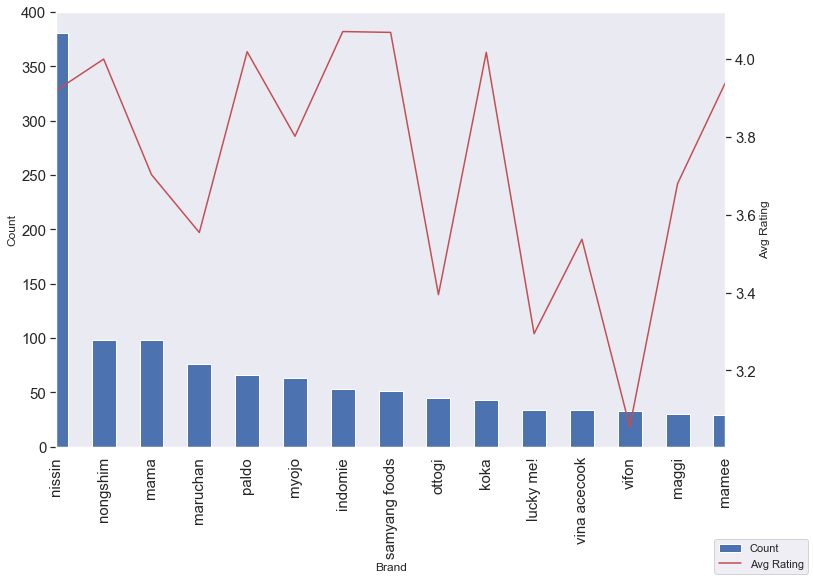

In [346]:
count_avg_plot(more_than_2, "Brand", "Count", "Avg Rating")

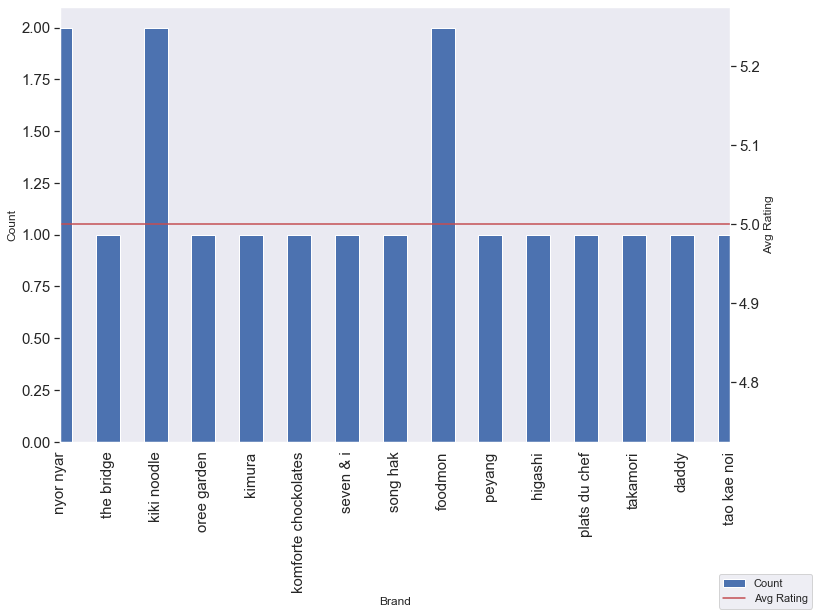

In [347]:
count_avg_plot(one_hit_wonders, "Brand", "Count", "Avg Rating")

In [13]:
def generate_concatenated_word_df(df):
    one = n_gram_df(df, 1)
    two = n_gram_df(df, 2)
    three = n_gram_df(df, 3)
    one = remove_words_from_df([two, three], one)
    two = remove_words_from_df([three], two)
    return pd.concat([one, two, three])

In [245]:
countries = np.unique(ratings.Country)
countries

array(['Australia', 'Bangladesh', 'Brazil', 'Cambodia', 'Canada', 'China',
       'Colombia', 'Dubai', 'Estonia', 'Fiji', 'Finland', 'Germany',
       'Ghana', 'Holland', 'Hong Kong', 'Hungary', 'India', 'Indonesia',
       'Japan', 'Malaysia', 'Mexico', 'Myanmar', 'Nepal', 'Netherlands',
       'Nigeria', 'Pakistan', 'Philippines', 'Poland', 'Sarawak',
       'Singapore', 'South Korea', 'Sweden', 'Taiwan', 'Thailand', 'UK',
       'USA', 'United States', 'Vietnam'], dtype=object)

In [289]:
top_word[0]

'chicken'

In [350]:
word_country_dict = {}
print('These are the most popular ramen styles/flavours by country!')
print('/n')
for country in countries:
    try:
        country_df = ratings[ratings.Country.isin([country])]
        top_word_df = generate_concatenated_word_df(country_df)
        top_word = top_word_df\
        .sort_values(by=['Frequency'], ascending= False) \
        ['Word'].head(3).values
        words_str = ', '.join(word for word in top_word)
        print(country,':', words_str)
    
        word_country_dict[country] = top_word[0]
    except:
        pass

These are the most popular ramen styles/flavours by country!
/n
Australia : chicken, mi goreng, beef
Bangladesh : oriental style, mr curry, mr beef
Brazil : calabresa, galinha caipira, lamen picanha
Cambodia : shrimp tom yum, minced pork, stewed beef
Canada : chicken, soup, beef
China : beef, artificial, spicy
Colombia : sopa con fideos, sopa instantánea con, instantánea con fideos
Finland : nuudeli, nuudeli kana nudlar, kana nudlar kyckling
Germany : soba, demae, beef
Ghana : beef light soup
Holland : good, sate, good chicken
Hong Kong : soup, spicy, seafood
Hungary : flavouring, shrimp, duck
India : masala, minute, curry
Indonesia : rasa, mi goreng, chicken
Japan : udon, shoyu, tonkotsu
Malaysia : perisa, penang white curry, taste
Mexico : sopa nissin, camaron, pollo
Myanmar : rangers snack, coconut milk, shrimp tom yum
Nepal : chicken, vegetable, rumpum
Netherlands : oriental, island flavours, soup
Pakistan : shoop, pizza, chatt patta
Philippines : chicken, supreme, pancit canton
Po

In [291]:
import pycountry
def generate_iso_alpha_list(country_dict):
    iso_alpha_list = []
    for country in country_dict.keys():
        try:
            iso_alpha_list.append(pycountry.countries.get(name=country).alpha_3)
        except Exception as e:
            try:
                iso_alpha_list.append(pycountry.countries.get(common_name=country).alpha_3)
            except Exception as e:
                print(country, e)
                pass
    return iso_alpha_list

In [292]:
del word_country_dict['Sarawak']
word_country_dict['United States'] = word_country_dict.pop('USA')
word_country_dict['United Kingdom'] = word_country_dict.pop('UK')
word_country_dict['Korea, Republic of'] = word_country_dict.pop('South Korea')
word_country_dict['Netherlands'] = word_country_dict.pop('Holland')

In [293]:
iso_alpha_list = generate_iso_alpha_list(word_country_dict)

country_word_df = pd.DataFrame(data={'Country':list(word_country_dict.keys()), 'Words':list(word_country_dict.values()), 'iso': iso_alpha_list})
country_word_df.head()

,Country,Words,iso
0,Australia,chicken,AUS
1,Bangladesh,oriental style,BGD
2,Brazil,calabresa,BRA
3,Cambodia,shrimp tom yum,KHM
4,Canada,chicken,CAN


In [294]:
import plotly.express as px

#df = px.data.gapminder().query("year==2007")
fig = px.choropleth(country_word_df, locations="iso",
                    color="Words", # lifeExp is a column of gapminder
                    hover_name="Country", # column to add to hover information
                   )
                    #color_continuous_scale=px.colors.sequential.Plasma)

fig.update_layout(
    title_text = 'Popular Ramen themes of the world!',
)
fig.show()

In [15]:
common_words = get_top_n_gram(ratings['Variety'],ngram = 1, n=40, stop_words=ramen_stop_words)
#common_words = [(word, freq) for word, freq in common_words if word not in ramen_common_words]
common_words_df = pd.DataFrame()
idx = 0
for word, freq in common_words:
    stats = get_df_words(str(word), ratings)
    mean, median = quick_stats(stats)
    generate_stats_df(idx, common_words_df, freq, mean, median, word)
    idx += 1


In [235]:
get_df_words('tonkotsu', ratings).sort_values(by=['Stars'], ascending=False).loc[705].Variety

'tonkotsu ramen artificially flavored tonkotsu white chicken broth'

In [271]:
all_words = generate_concatenated_word_df(ratings)
all_words_sorted = all_words[all_words.Frequency > 10].sort_values(by=['Median Rating'], ascending=False).head(20)


In [272]:
all_words_sorted.head()

,Word,Frequency,Mean Rating,Median Rating
0,penang white curry,19.0,4.887500,5.00
24,penang,54.0,4.675926,5.00
42,creamy,36.0,4.319444,4.75
1,mi goreng,56.0,4.233036,4.40
45,laksa,35.0,4.185714,4.25


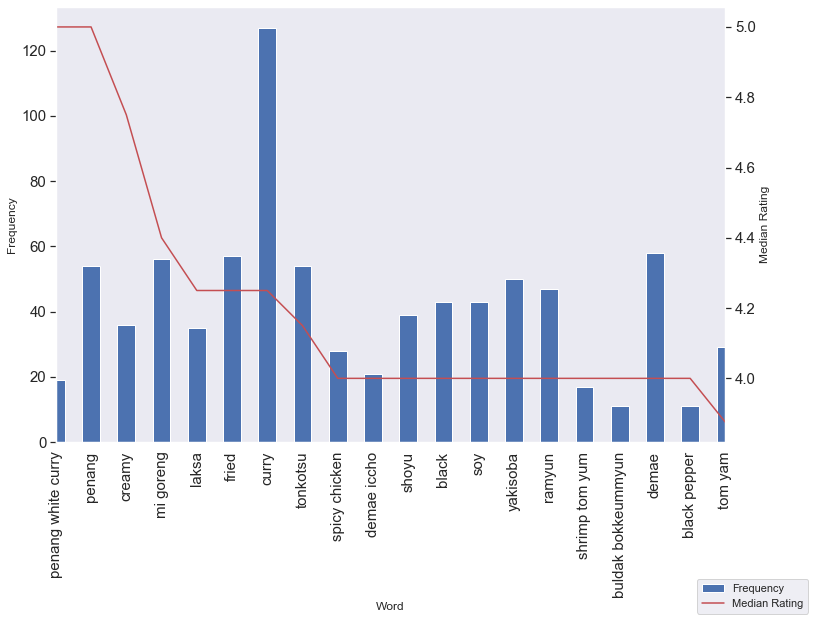

In [348]:
count_avg_plot(all_words_sorted, "Word", "Frequency", "Median Rating")

In [303]:
all_words_sorted.head()

,Word,Frequency,Mean Rating,Median Rating
0,penang white curry,19.0,4.887500,5.00
24,penang,54.0,4.675926,5.00
42,creamy,36.0,4.319444,4.75
1,mi goreng,56.0,4.233036,4.40
45,laksa,35.0,4.185714,4.25


In [229]:
all_words[all_words.Frequency > 10].sort_values(by=['Median Rating'], ascending=False).head(20)

,Word,Frequency,Mean Rating,Median Rating
123,singapore,13.0,4.553571,5.000
25,penang,54.0,4.675926,5.000
146,aloe,11.0,4.340909,5.000
0,penang white curry,19.0,4.887500,5.000
55,taste,32.0,4.492188,5.000
132,veggie,12.0,4.187500,5.000
149,jumbo,11.0,4.500000,5.000
103,raoh,16.0,4.781250,5.000
144,sichuan,11.0,3.977273,4.750
115,chef,15.0,4.383333,4.750


In [25]:
get_df_words('tonkotsu', ratings).sort_values(by='Stars', ascending = False).head()

,Review #,Brand,Variety,Style,Country,Stars,Top Ten,Varity Tokenized,Variety Bigrams,Variety Trigrams
11,2569,yamachan,yokohama tonkotsu shoyu,Pack,USA,5.0,NaN,"[yokohama, tonkotsu, shoyu]","[(yokohama, tonkotsu), (tonkotsu, shoyu)]","[(yokohama, tonkotsu, shoyu)]"
1095,1485,nongshim,spicy tonkotsu noodle soup,Pack,USA,5.0,NaN,"[spicy, tonkotsu, noodle, soup]","[(spicy, tonkotsu), (tonkotsu, noodle), (noodl...","[(spicy, tonkotsu, noodle), (tonkotsu, noodle,..."
525,2055,nissin,tokyo tokunou gyokai tonkotsu,Bowl,Japan,5.0,NaN,"[tokyo, tokunou, gyokai, tonkotsu]","[(tokyo, tokunou), (tokunou, gyokai), (gyokai,...","[(tokyo, tokunou, gyokai), (tokunou, gyokai, t..."
514,2066,marutai,hakata tonkotsu ramen,Pack,Japan,5.0,NaN,"[hakata, tonkotsu, ramen]","[(hakata, tonkotsu), (tonkotsu, ramen)]","[(hakata, tonkotsu, ramen)]"
496,2084,nissin,demae ramen straight noodle kyushu tonkotsu in...,Pack,Hong Kong,5.0,NaN,"[demae, ramen, straight, noodle, kyushu, tonko...","[(demae, ramen), (ramen, straight), (straight,...","[(demae, ramen, straight), (ramen, straight, n..."


In [307]:
get_df_words('penang white curry', ratings).sort_values(by='Stars', ascending = False).head()

,Review #,Brand,Variety,Style,Country,Stars,Top Ten,Varity Tokenized,Variety Bigrams,Variety Trigrams
28,2552,mykuali,penang white curry rice vermicelli soup,Bowl,Malaysia,5.0,NaN,"[penang, white, curry, rice, vermicelli, soup]","[(penang, white), (white, curry), (curry, rice...","[(penang, white, curry), (white, curry, rice),..."
770,1810,mykuali,penang white curry noodle (new version),Pack,Malaysia,5.0,NaN,"[penang, white, curry, noodle, (, new, version...","[(penang, white), (white, curry), (curry, nood...","[(penang, white, curry), (white, curry, noodle..."
1030,1550,ibumie,penang white currymee,Pack,Malaysia,5.0,NaN,"[penang, white, currymee]","[(penang, white), (white, currymee)]","[(penang, white, currymee)]"
966,1614,the bridge,penang white curry noodle,Pack,Malaysia,5.0,NaN,"[penang, white, curry, noodle]","[(penang, white), (white, curry), (curry, nood...","[(penang, white, curry), (white, curry, noodle)]"
957,1623,mykuali,penang white curry noodle (new improved tatse),Pack,Malaysia,5.0,NaN,"[penang, white, curry, noodle, (, new, improve...","[(penang, white), (white, curry), (curry, nood...","[(penang, white, curry), (white, curry, noodle..."


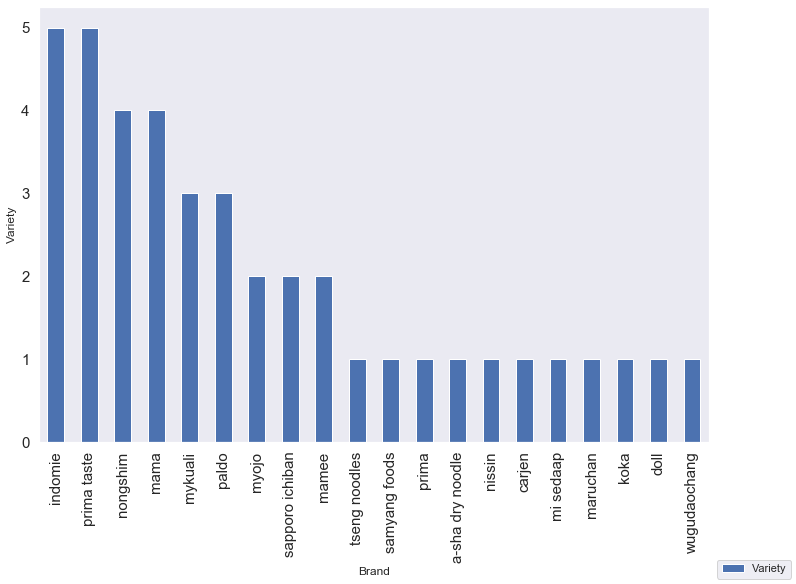

In [349]:
top_ten = ratings[~ratings['Top Ten'].isnull()]
top_ten_brands = top_ten[['Brand', 'Variety']]\
.groupby(['Brand'], as_index=False).count().sort_values(by=['Variety'], ascending=False)

count_avg_plot(top_ten_brands, 'Brand', 'Variety')